In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 

df = pd.read_csv("/media/naman/NewVolume/Data_Science/csv_data/Corona_NLP_train.csv", encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [2]:
df.OriginalTweet[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [3]:
# unique sentiments

print(df.Sentiment.unique(), "\nShape: ",df.shape)

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive'] 
Shape:  (41157, 6)


In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_wrds = stopwords.words('english')

print("Initial 10 stopwords: ",stop_wrds[:10])

Initial 10 stopwords:  ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [5]:
# preprocessing the text, removing puntuations, stopwords, links and @ usernames

texts=[]
for i in range(len(df)):
    text = re.sub(r'@\w+', '', df['OriginalTweet'][i])
    text = text.lower()
    text = [word for word in text.split() if word not in stop_wrds]
    text = " ".join(text) 
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = text.split()
    text = " ".join(text)    
    texts.append(text)

In [6]:
dataset = pd.DataFrame(texts, columns=['text'])
dataset['length'] = dataset['text'].apply(lambda x: len(x.split()))
dataset['sentiment'] = df['Sentiment']
print(dataset.shape)

(41157, 3)


In [7]:
# keeping only those text with length > 3

dataset = dataset.query("length>3")

display(dataset.sample(7))
print(dataset.shape)

,text,length,sentiment
25307,covid victims management survivers help centre...,24,Positive
37153,single man toilet paper seeks woman hand sanit...,13,Extremely Positive
37568,check latest email updates related covid see h...,27,Positive
9611,hear out covid came age online shopping online...,26,Neutral
34028,critical start preparing election look like co...,23,Extremely Positive
19772,understandable reasons much comment consumer p...,15,Negative
8886,illinois stay home order begins saturday pm en...,28,Negative


(40831, 3)


In [8]:
# model to create word embeddings using word2vec

from gensim.models import Word2Vec
sentences = list(dataset['text'].apply(lambda x: x.split(' ')))
w2v = Word2Vec(sentences, vector_size=70, workers=4, sg=0, negative=10)

# printing words vocabulary
words = list(w2v.wv.key_to_index)
print(words[:10])

['covid', 'coronavirus', 'prices', 'food', 'supermarket', 'store', 'grocery', 's', 'people', 'amp']


In [11]:
# transforming input text into vectors

x = dataset['text']
y = dataset['sentiment']

def text_to_vector(model, text, max_len):
    words = text.split()
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    if len(vectors) > max_len:
        diff = len(vectors) - max_len
        diff = (diff//2, diff//2) if diff%2==0 else (diff//2, diff//2+1)
        vectors = vectors[diff[0]:len(vectors)-diff[1]]
    else:
        vectors += [np.zeros(model.vector_size)]* (max_len - len(vectors))
    return np.array(vectors)

max_len = 15
X = np.array([text_to_vector(w2v, text, max_len) for text in dataset['text']])

print(X.shape)

(40831, 15, 70)


In [12]:
# for encoding target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(dataset['sentiment'])
num_classes = len(le.classes_)
print(num_classes)

5


In [17]:
# building RNN model

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

model = Sequential([
    SimpleRNN(32, input_shape=(max_len, 70), return_sequences=False),    
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                3296      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3461 (13.52 KB)
Trainable params: 3461 (13.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
hist = model.fit(X, y, validation_split=0.2, batch_size=32, epochs=10)

Epoch 1/10
1021/1021 [==============================] - 19s 16ms/step - loss: 1.5582 - accuracy: 0.3038 - val_loss: 1.4283 - val_accuracy: 0.3688
Epoch 2/10
1021/1021 [==============================] - 15s 15ms/step - loss: 1.4289 - accuracy: 0.3665 - val_loss: 1.3922 - val_accuracy: 0.3874
Epoch 3/10
1021/1021 [==============================] - 15s 15ms/step - loss: 1.4017 - accuracy: 0.3846 - val_loss: 1.3950 - val_accuracy: 0.3814
Epoch 4/10
1021/1021 [==============================] - 15s 15ms/step - loss: 1.3834 - accuracy: 0.3937 - val_loss: 1.3496 - val_accuracy: 0.4167
Epoch 5/10
1021/1021 [==============================] - 15s 15ms/step - loss: 1.3686 - accuracy: 0.4011 - val_loss: 1.3556 - val_accuracy: 0.4038
Epoch 6/10
1021/1021 [==============================] - 16s 15ms/step - loss: 1.3589 - accuracy: 0.4046 - val_loss: 1.3379 - val_accuracy: 0.4150
Epoch 7/10
1021/1021 [==============================] - 16s 15ms/step - loss: 1.3540 - accuracy: 0.4091 - val_loss: 1.3310 -

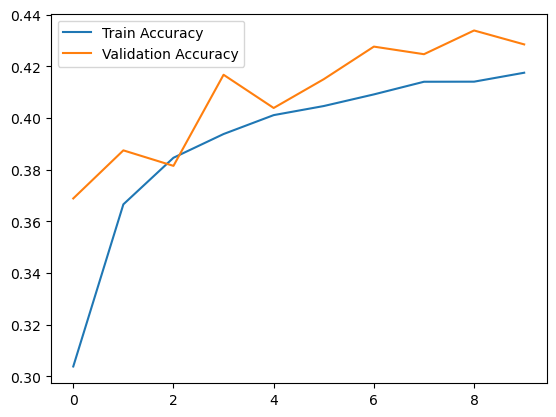

In [19]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [8]:
x = dataset['text']
y = dataset['sentiment']

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(dataset['sentiment'])
num_classes = len(le.classes_)
print(num_classes)

5


In [10]:
le.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

In [11]:
dataset

,text,length,sentiment
1,advice talk neighbours family exchange phone n...,27,Positive
2,coronavirus australia woolworths give elderly ...,12,Positive
3,food stock one empty please panic enough food ...,23,Positive
4,me ready go supermarket covid outbreak paranoi...,22,Extremely Negative
5,news region s first confirmed covid case came ...,26,Positive
...,...,...,...
41152,airline pilots offering stock supermarket shel...,9,Neutral
41153,response complaint provided citing covid relat...,16,Extremely Negative
41154,know it s getting tough rationing toilet paper...,14,Positive
41155,wrong smell hand sanitizer starting turn on co...,10,Neutral


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
x

1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please panic enough food ...
4        me ready go supermarket covid outbreak paranoi...
5        news region s first confirmed covid case came ...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    know it s getting tough rationing toilet paper...
41155    wrong smell hand sanitizer starting turn on co...
41156    well new used rift going amazon rn although no...
Name: text, Length: 40831, dtype: object

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=6000)

X_train_bow = tf.fit_transform(X_train)
X_test_bow = tf.transform(X_test)

In [36]:
X_train_bow.shape, X_test_bow.shape

((32664, 6000), (8167, 6000))

In [37]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()

gnb.fit(X_train_bow,y_train)

MultinomialNB()

In [38]:
print("Accuracy:", gnb.score(X_test_bow, y_test))

Accuracy: 0.47483776172401126
